# Classificazione di Testi Spam e NON-Spam

Lo scopo di questo progetto consiste nella costruzione e nella valutazione di un classificatore basato su algoritmi di Machine Learning, per il riconoscimento di messaggi **spam** dai messaggi **non-spam**.

Essendo, il suddetto, un progetto a scopo didattico, si faranno svariati richiami teorici nella spiegazione delle diverse attività svolte, inoltre, tutti i riferimenti ad articoli che sono stati utili per la realizzazione di questo progetto sono disponibili nell'ultima sezione di questo notebook, inclusa la fonte dalla quale è stato ottenuto l'unico dataset utilizzato. Il Dataset in questione consta di circa 5500 righe, in formato csv, e in ogni riga troviamo una stringa di testo, la quale rappresenta il messaggio da valutare, e un'etichetta in formato testuale autoesplicativa, con due valori ammessi (spam, ham).

Importiamo le librerie:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from os.path import join, dirname
from keras.preprocessing.text import Tokenizer
from joblib import dump
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

Andiamo a leggere il dataset precaricato sfruttando le funzionalità della libreria *pandas*:

In [2]:
df = pd.read_csv("spam_messages.csv")
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Come possiamo osservare da questa proiezione del dataset, i messaggi di spam comprendono un ampio spettro di contesti, ma principalmente si tratta di **pubblicità indesiderata**.

In [3]:
df.where(df["Category"] == "spam").dropna()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [4]:
df.describe().transpose()

,count,unique,top,freq
Category,5572,2,ham,4825
Message,5572,5157,"Sorry, I'll call later",30


## Distribuzione delle etichette del Dataset

<AxesSubplot: xlabel='Category', ylabel='count'>

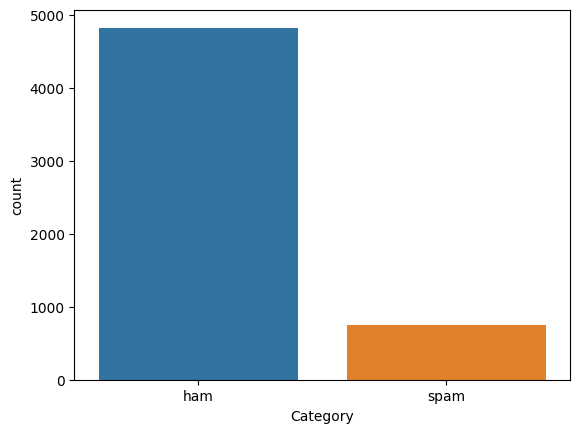

In [5]:
sns.countplot(x=df["Category"])

Come si può osservare nel grafico a barre riportato di sopra, la distribuzione delle etichette è particolarmente sbilanciata, questo potrebbe portare a problematiche nelle fasi successive all'apprendimento.

Prima di poter lavorare adeguatamente con i nostri dati, procediamo con la separazione delle due variabili del nostro Dataset:

In [6]:
messages = df['Message']
labels = df['Category']

Definiamo una serie di variabili e costanti che ci saranno utili nelle fasi successive:

In [7]:
MAX_TEXT_LEN = messages.map(lambda message: len(message)).max()
print(f"The max count of characters is {MAX_TEXT_LEN}")

The max count of characters is 910


In [8]:
MODEL_PATH = "training_1/model"
model_dir = dirname(MODEL_PATH)
tokenizer_path = join(model_dir, "tokenizer.joblib")

## Distribuzione dei conteggi delle parole

Lo svolgimento di questa fase si rende necessario nel momento in cui, nelle fasi successive all'addestramento, si voglia trovare una correlazione tra errori commessi dal modello e la lunghezza dei messaggi.

## Addestramento del modello

A questo punto la classe 0 sarà associata all'etichetta **spam**, invece la classe 1 all'etichetta **ham**.

In [9]:
X = messages
y = np.where(labels == "ham", 1, 0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(messages, y, test_size=0.2, random_state=1)
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 4457
Test sample size: 1115


Andiamo a sostituire dai nostri messaggi tutte le cifre che appariranno con un simbolo *#*, in questo modo saranno ignorate in fase di tokenizzazione.

In [11]:
X_train = X_train.map(lambda message: ''.join(["#" if c.isdigit() else c for c in message]))
X_train

1642    Hi , where are you? We're at  and they're not ...
2899          If you r @ home then come down within # min
480     When're you guys getting back? G said you were...
3485    Tell my  bad character which u Dnt lik in me. ...
157                           I'm leaving my house now...
                              ...                        
905     We're all getting worried over here, derek and...
5192    Oh oh... Den muz change plan liao... Go back h...
3980    CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...
235     Text & meet someone sexy today. U can find a d...
5157                              K k:) sms chat with me.
Name: Message, Length: 4457, dtype: object

### Tokenizzazione dei messaggi

In supporto alla Tokenizzazione, giunge in aiuto la potentissima classe *Tokenizer*, fornita da TensorFlow. Questa classe consente di vettorializzare un testo, trasformando ogni testo in una sequenza di interi, nel nostro caso ogni intero è l'indice di un token in un dizionario.

Nella prima fase di utilizzo nel nostro "tokenizzatore", andiamo a costruire il nostro dizionario a partire dal dataset di apprendimento.

In [12]:
tokenizer = Tokenizer(
    oov_token = "#",
)
tokenizer.fit_on_texts(X_train)
dump(tokenizer, tokenizer_path)
VOCABULARY_SIZE = len(tokenizer.word_index)

Verifichiamo la dimensione del dizionario appena raccolto e traiamo delle considerazioni a riguardo.

La taglia del vocabolario sembrerebbe essere nulla rispetto alla gamma di terminologie usate realmente nell'ambiente della messaggistica.

In [13]:
print(f"Il dizionario contiene di {VOCABULARY_SIZE} token")

Il dizionario contiene di 7102 token


In [14]:
X_train_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=190)
X_test_tokenized = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=190)

I livelli sono impilati in sequenza per costruire il classificatore:

- Il primo livello è un livello di *Embedding*. Questo livello prende i messaggi tokenizzati e cerca un vettore di incorporamento per ogni indice di parola. I vettori aggiungono una dimensione all'array di output.

- I livelli Dropout impostano in modo casuale le unità di input su 0 con una frequenza di *rate* (passata come unico argomento) a ogni passaggio durante la fase di addestramento, che aiuta a prevenire l'overfitting. Gli input non impostati su 0 vengono aumentati di 1/(1 - rate) in modo tale che la somma di tutti gli input rimanga invariata.

- Successivamente, un livello *GlobalAveragePooling1D* restituisce un vettore di output a lunghezza fissa per ogni esempio calcolando la media sulla dimensione della sequenza. Ciò consente al modello di gestire input di lunghezza variabile, nel modo più semplice possibile.

- L'ultimo strato è densamente connesso con un singolo nodo di output.

Poiché si tratta di un problema di classificazione binaria e il modello emette una probabilità (uno strato di unità singola con un'attivazione sigmoidea).

Un grande aiuto per la costruzione del modello in questione è stato fornito dalle innumerevoli guide sull'utilizzo di TensorFlow, andando ad apportare piccole modifiche al codice fornito, basandosi su osservazioni fatte durante lo svolgimento delle diverse attività: [Basic text classification | TensorFlow Core](https://www.tensorflow.org/tutorials/keras/text_classification?hl=it)

In [15]:
metrics = [
  tf.keras.metrics.TruePositives(name='th'),
  tf.keras.metrics.FalsePositives(name='fh'),
  tf.keras.metrics.TrueNegatives(name='ts'),
  tf.keras.metrics.FalseNegatives(name='fs'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

model = tf.keras.Sequential([
  tf.keras.layers.Embedding(VOCABULARY_SIZE, 128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(metrics=metrics, loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         909056    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                        

Seguendo il suggerimento ricevuto durante la prima presentazione di questo progetto, andiamo a porre un maggiore peso alla classe che risulta essere in minoranza. La modalità di impostazione di questi pesi è stata derivata dalla documentazione di TensorFlow.

La scelta dei pesi è pienamente imputabile a valutazioni empiriche effettuate reiterando l'attività di addestramento, apportando di volta in volta modifiche ai diversi pesi, fino al raggiungimento di un risultato *soddisfacente*.

Andiamo a chiarire il significato del parametro **validation_split**, questo corrisponde alla frazione dei dati di addestramento da utilizzare come dati di convalida. Il modello separerà questa frazione dei dati di addestramento, non si addestrerà su di essa e valuterà la perdita e qualsiasi metrica del modello su questi dati alla fine di ogni epoca.

In [16]:
history = model.fit(X_train_tokenized, y_train, batch_size=20, epochs=30, validation_split=0.2, verbose=1, class_weight={ 0: 1, 1: 0.2 })

Epoch 1/30
179/179 [==============================] - 3s 10ms/step - loss: 0.2087 - th: 3040.0000 - fh: 475.0000 - ts: 5.0000 - fs: 45.0000 - accuracy: 0.8541 - precision: 0.8649 - recall: 0.9854 - val_loss: 0.5803 - val_th: 772.0000 - val_fh: 120.0000 - val_ts: 0.0000e+00 - val_fs: 0.0000e+00 - val_accuracy: 0.8655 - val_precision: 0.8655 - val_recall: 1.0000
Epoch 2/30
179/179 [==============================] - 1s 8ms/step - loss: 0.2024 - th: 3085.0000 - fh: 480.0000 - ts: 0.0000e+00 - fs: 0.0000e+00 - accuracy: 0.8654 - precision: 0.8654 - recall: 1.0000 - val_loss: 0.5709 - val_th: 772.0000 - val_fh: 119.0000 - val_ts: 1.0000 - val_fs: 0.0000e+00 - val_accuracy: 0.8666 - val_precision: 0.8664 - val_recall: 1.0000
Epoch 3/30
179/179 [==============================] - 1s 8ms/step - loss: 0.1898 - th: 3085.0000 - fh: 416.0000 - ts: 64.0000 - fs: 0.0000e+00 - accuracy: 0.8833 - precision: 0.8812 - recall: 1.0000 - val_loss: 0.5626 - val_th: 771.0000 - val_fh: 31.0000 - val_ts: 89.0000

Salviamo il nostro modello addestrato nel file-system per poterlo utilizzare successivamente in un ambiente reale.

In [17]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: training_1/model\assets


<AxesSubplot: >

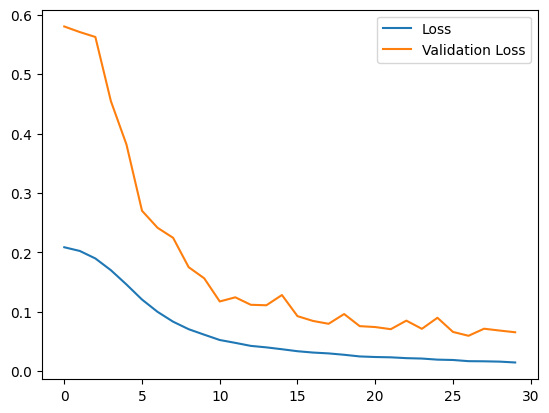

In [18]:
sns.lineplot(history.history["loss"], label="Loss")
sns.lineplot(history.history["val_loss"], label="Validation Loss")

## Comprensione dei risultati

Il nostro modello è stato addestrato, con dei risulati apparentemente soddisfacenti. Ciò però non significa necessariamente che il suo comportamento sia quello da noi desiderato.

In [19]:
y_predict_ann = model.predict(X_test_tokenized).flatten()

35/35 [==============================] - 0s 1ms/step


In [20]:
y_predict_labels = np.where(y_predict_ann > 0.5, 1, 0)

### Accuratezza

L'accuratezza è una metrica per valutare i modelli di classificazione. A grandi linee, l'accuratezza è la parte della previsione che il nostro modello ha fatto in modo corretto. Formalmente, l'accuratezza è definita come segue:

$
Accuracy = {TP+TN \over TP+FP+TN+FN} = {\text{Numero di previsioni corrette}\over\text{Numero di predizioni totali}}
$

In [21]:
ann_accuracy_score = accuracy_score(y_test, y_predict_labels)
ann_accuracy_score

0.9874439461883409

### Precisione

La precisione misura quale proporzione di identificatori positivi è effettivamente corretta, ed è definita come segue:

$
Precision = {TP \over{TP + FP}}
$

In [22]:
ann_precision_score = precision_score(y_test, y_predict_labels)
ann_precision_score

0.9937888198757764

### Matrice di confusione

Si rende molto utile in questa fase di comprensione dei dati, l'utilizzo di una **matrice di confusione** per una rappresentazione dei *risultati ottenuti dal modello*. Calcoliamo quindi per ogni etichetta quante sono le entry per le quali le etichette sono state correttamente predette dal modello nel *dataset di test* e quali invece sono state sbagliate.

In [23]:
ann_cf_matrix = confusion_matrix(y_test, y_predict_labels)
ann_cf_matrix[0] = (ann_cf_matrix[0] / sum(ann_cf_matrix[0]))*100
ann_cf_matrix[1] = (ann_cf_matrix[1] / sum(ann_cf_matrix[1]))*100

<AxesSubplot: >

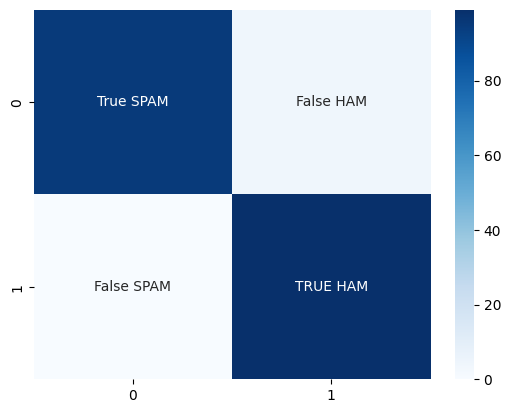

In [24]:
sns.heatmap(ann_cf_matrix, fmt="", cmap="Blues", annot=[["True SPAM", "False HAM"], ["False SPAM", "TRUE HAM"]])

A differenza di quel che si poteva immaginare, la maggior frequenza degli errori è in corrispondeza delle frasi con un più basso conteggio di parole, fattore incentivato, probabilmente dalla loro elevata distribuzione.

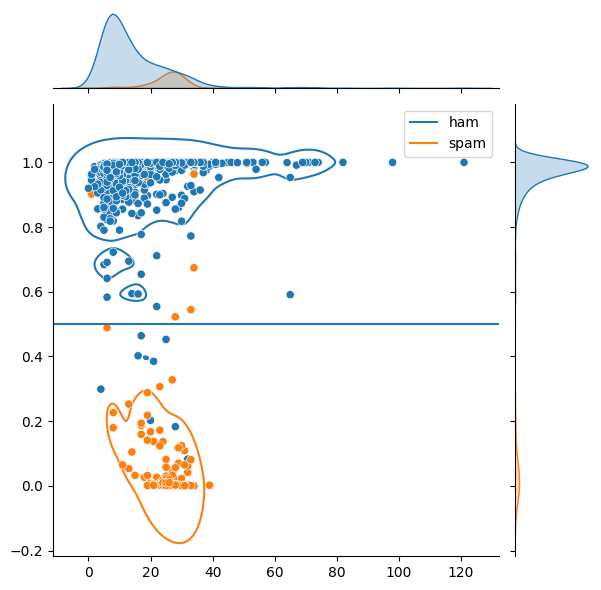

In [25]:
X_test_lenghts = [len([t for t in X if t != 0]) for X in X_test_tokenized]
plot = sns.jointplot(x=X_test_lenghts, y=y_predict_ann, hue=np.where(y_test == 1, "ham", "spam"))\
.plot_joint(sns.kdeplot, color="r", zorder=0, levels=1)
plot.ax_joint.axhline(y=0.5)

## Valutazione delle Alternative

L'utilizzo di una rete neurale è davvero giustificato per problemi come questo? Una giusta osservazione che sorge, è appunto la necessità di utilizzare una tecnologia tanto complessa e costosa come la rete neurale per la risoluzione di problemi di classificazione binaria.

Per ottenere una rapida risposta a questo quesito, nella presente sezione metteremo a confronto risoluzione del problema sfruttando un ulteriore algoritmo di classificazione: **Naive Bayes**. La libreria Scikit-Learn ci fornisce diverse implementazioni per l'algoritmo Naive Bayes: [Naive Bayes - scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html). Tra le tante, la scelta è comunque ricaduta sul *Multinomial Naive Bayes*.

Assumendo dunque corrette, le modifiche applicate al datase, iniziamo da quì una nuova fase di apprendimento, sfruttando l'algoritmo *MultinomialNB* importato, stavolta, come citato in precedenza, dalla libreria *Scikit-Learn*.

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
mnb = MultinomialNB()

In [28]:
mnb.fit(X_train_tokenized, y_train)
y_predict_nb = mnb.predict(X_test_tokenized)

### Valutazione dei risultati

#### Accuratezza

In [29]:
nb_accuracy_score = accuracy_score(y_test, y_predict_nb)
nb_accuracy_score

0.7695067264573991

#### Precisione

In [30]:
nb_precision_score = precision_score(y_test, y_predict_nb)
nb_precision_score

0.9721115537848606

In [34]:
nb_cf_matrix = confusion_matrix(y_test, y_predict_nb)
nb_cf_matrix[0] = (nb_cf_matrix[0] / sum(nb_cf_matrix[0]))*100
nb_cf_matrix[1] = (nb_cf_matrix[1] / sum(nb_cf_matrix[1]))*100

<AxesSubplot: >

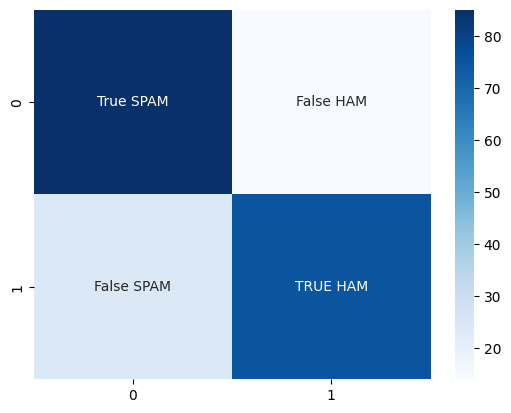

In [35]:
sns.heatmap(nb_cf_matrix, fmt="", cmap="Blues", annot=[["True SPAM", "False HAM"], ["False SPAM", "TRUE HAM"]])

Le matrici di confusione ottenute, ci riportano in entrambi i casi risultati abbastanza soddisfacenti, anche se leggermente migliori nel caso dell'uso della rete neurale. Dunque, l'uso di un algoritmo di questo tipo risulta essere giustificato? Apparentemente **NO!** Infatti, il modello basato su Naive Bayes, ha riportato dei risultati comunque soddisfacenti, messi a confronto con quelli ottenuti dalla rete neurale. Chiaramente escludendo riscontri che potrebbero essere visibili solo in fase di distribuzione del modello in un ambiente reale.

### Confronto tra i modelli

Possiamo concludere che il vantaggio ottenuto dall'uso della rete neurale è impercettibile.

<AxesSubplot: >

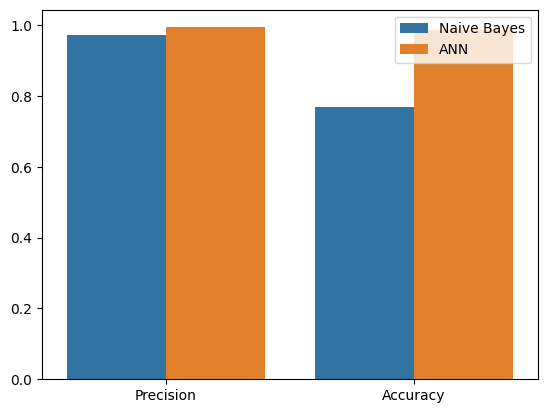

In [36]:
sns.barplot(
    x=["Precision", "Accuracy", "Precision", "Accuracy"],
    y=[nb_precision_score, nb_accuracy_score, ann_precision_score, ann_accuracy_score],
    hue=["Naive Bayes", "Naive Bayes", "ANN", "ANN"],
)

## Conclusioni

Seppure il modello basato su una rete neurale abbia totalizzato un'accuratezza molto alta, andando a visualizzare in dettaglio i risultati, si nota che il modello è più bravo a riconoscere casi di Non-Spam piuttosto che casi di Spam. Questo fattore potrebbe assolutamente essere riconducibile allo sbilanciamento delle etichette. Nonostante l'elevata accuratezza del modello nella classificazione di dati provenienti dal Dataset utilizzato per l'apprendimento, il suo comportamento presenta molti dubbi nel caso in cui lo si utilizzi per predirre l'etichetta di nuove stringe (magari scritte a mano). Questo comportamento potrebbe essere una delle conseguenze della scarsa numerosità dei dati.

### Possibili utilizzi del modello e osservazioni

Sulla base dei nostri risultati e della sperimentazione sul modello svolta mediante uno script Python realizzato ad-hoc, un modello di questo tipo può essere utilizzato in combinazione con uno svariato numero di ambienti. Un tipico esempio è il filtraggio dei commenti per le piattaforme blogging, o per un form di raccolta di questionari. Purtroppo però, le vulnerabilità del modello in questione sono diverse, infatti, un qualsiasi usufruitore correrebbe in ogni caso il rischio di vedere i suoi innocenti messaggi classificati come SPAM... D'altronde questo è un fenomeno assai frequente anche nell'utilizzo di noti servizi di posta elettronica come *Gmail* o *Outlook*.

Nasce quindi spontanea una domanda, è più grave un **falso spam** o un **falso ham**? La domanda, come al solito potrebbe essere risolta con un più che generico "dipende", che aprirebbe la nostra mente verso una serie di specializzazioni applicabili al dominio di un problema di questo tipo: dipende dal messaggio? dipende dal mittente? dipende dai messaggi precedentemente scambiati con il mittente?

## Fonti

Di seguito sono riportati articoli e fonti da cui sono state raccolte tutte le info necessarie per la realizzazione di questo progetto. Un aiuto molto importante a questo progetto è stato fornito dalle innumerevoli e utilissime guide fornite da TensorFlow.

[Basic text classification | TensorFlow Core](https://www.tensorflow.org/tutorials/keras/text_classification?hl=it)

[Save and load models | TensorFlow Core](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=it)

[Classification on imbalanced data | TensorFlow Core](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=it)

[Spam Text Message Classification](https://www.kaggle.com/datasets/team-ai/spam-text-message-classification)

[Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)